In [3]:
import torch,math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torch.nn as NN
torch.__version__

'1.10.0+cu111'

# Fashion MNIST进行分类 
## Fashion MNIST 介绍
Fashion MNIST数据集 是kaggle上提供的一个图像分类入门级的数据集，其中包含`10个类别`的`70000个灰度图像`。如图所示，这些图片显示的是每件衣服的低分辨率(28×28像素)

数据集的下载和介绍：[地址](https://www.kaggle.com/zalando-research/fashionmnist/)


Fashion MNIST的目标是作为经典MNIST数据的替换——通常被用作计算机视觉机器学习程序的“Hello, World”。

`MNIST数据集`包含`手写数字(0-9等)的图像`，格式与我们将在这里使用的衣服相同，MNIST只有手写的0-1数据的复杂度不高，所以他只能用来做“Hello, World”

而Fashion MNIST 的由于使用的是衣服的数据，比数字要复杂的多，并且图片的内容也会更加多样性，所以它是一个比常规MNIST稍微更具挑战性的问题。

Fashion MNIST这个数据集相对较小，用于验证算法是否按预期工作。它们是测试和调试代码的好起点。

## 数据集介绍

### 分类
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 
```
### 格式

fashion-mnist_test.csv

fashion-mnist_train.csv

存储的训练的数据和测试的数据，格式如下：

label是分类的标签
pixel1-pixel784是每一个像素代表的值 因为是`灰度图像`，所以是一个`0-255`之间的数值。

为什么是784个像素？ 28 * 28 = 784

### 数据提交

Fashion MNIST不需要我们进行数据的提交，数据集中已经帮助我们将训练集和测试集分好了，我们只需要载入、训练、查看即可，所以Fashion MNIST 是一个非常好的入门级别的数据集


In [4]:
## 下载数据集到云端硬盘
from google.colab import drive

drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
!pip install kaggle
import kaggle
!kaggle datasets download -d zalando-research/fashionmnist -p /content/drive/MyDrive/datasets/Fashion-minist

!unzip /content/drive/MyDrive/datasets/Fashion-minist/fashionmnist.zip

Mounted at /content/drive


In [5]:
#指定数据目录
DATA_PATH=Path('/content/drive/MyDrive/datasets/Fashion-minist')

## 训练数据
train = pd.read_csv(DATA_PATH / "fashion-mnist_train.csv");
train.head(10)

## 测试数据
test = pd.read_csv(DATA_PATH / "fashion-mnist_test.csv");
test.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,0,0,0,0,0,0,0,0,0,0,0,34,68,34,0,0,0,0,0,0,0,0,0,34,136,102,105,98,74,64,...,129,122,125,139,132,132,10,0,0,0,0,0,0,0,0,0,0,0,0,23,57,105,108,115,125,125,122,122,125,119,105,64,30,0,0,0,0,0,0,0
6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,1,0,0,0,108,25,0,0,0,132,54,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11,61,102,...,146,196,197,136,215,42,0,3,0,0,0,0,0,0,0,0,0,0,1,0,82,172,159,150,140,142,164,160,153,202,174,136,155,31,0,1,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,75,192,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,92,66,0,0,0,0,81,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,75,111,118,...,121,117,104,110,69,0,0,1,0,0,0,0,0,0,0,0,0,0,0,49,63,52,55,57,57,55,53,53,55,61,57,70,28,0,2,0,0,0,0,0


ubyte文件标识了数据的格式

其中idx3的数字表示数据维度。也就是图像为3维，
idx1 标签维1维。

具体格式详解：http://yann.lecun.com/exdb/mnist/

In [ ]:
import struct
from PIL import Image 

with open(DATA_PATH / "train-images-idx3-ubyte", 'rb') as file_object:
    header_data=struct.unpack(">4I",file_object.read(16))
    print(header_data)

如下是训练的图片的二进制格式

    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    
有四字节的header_data，故使用`unpack_from`进行二进制转换时，偏置offset=16

In [ ]:
## 图片
with open(DATA_PATH / "train-images-idx3-ubyte", 'rb') as file_object:
    raw_img=file_object.read()
img = struct.unpack_from(">784B",raw_img,16)
image = np.asarray(img)
image = image.reshape((28,28))
print(image.shape)
plt.imshow(image,cmap = plt.cm.gray)
plt.show()

In [ ]:
## 标签
with open(DATA_PATH / "train-labels-idx1-ubyte", 'rb') as file_object:
    raw_img = file_object.read(1)
    label = struct.unpack(">B",raw_img)
    print(label)

这里好像有点错误，显示的错位了，但是我的确是按照格式进行处理的。这种格式处理起来比较复杂，并且数据集中的`csv直接给出了每个像素的值`，所以这里我们可以直接使用csv格式的数据。

In [6]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = pd.read_csv(csv_file)
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28).astype(float)
        self.Y = np.array(data.iloc[:, 0]);
        del data;  #结束data对数据的引用,节省空间
        self.len=len(self.X)

    def __len__(self):
        #return len(self.X)
        return self.len
        
    
    def __getitem__(self, idx):
        item = self.X[idx]
        label = self.Y[idx]
        return (item, label)

对于自定义的数据集，只需要实现三个函数：

`__init__`： 初始化函数主要用于`数据的加载`，这里直接使用pandas将数据读取为dataframe，然后将其`转成numpy数组`来进行索引

`__len__`： 返回数据集的总数，pytorch里面的`datalorder需要知道数据集的总数`

`__getitem__`：会返回单张图片，它包含一个index，返回值为样本及其标签。



In [7]:
## 创建训练和测试集
train_dataset = FashionMNISTDataset(csv_file=DATA_PATH / "fashion-mnist_train.csv")
test_dataset = FashionMNISTDataset(csv_file=DATA_PATH / "fashion-mnist_test.csv")

在使用Pytorch的DataLoader读取数据之前，需要指定一个`batch size` 这也是一个超参数，涉及到内存的使用量，如果出现OOM的错误则要减小这个数值，一般这个数值都为2的幂或者2的倍数。

In [8]:
#因为是常量，所以大写，需要说明的是，这些常量建议都使用完整的英文单词，减少歧义
BATCH_SIZE=256 # 这个batch 可以在M250的笔记本显卡中进行训练，不会oom

In [9]:
## 我们接着使用dataloader模块来使用这些数据
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True) # shuffle 标识要打乱顺序

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False) # shuffle 标识要打乱顺序，测试集不需要打乱

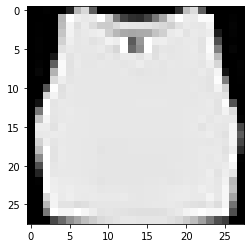

In [10]:
## 查看一下数据
a=iter(train_loader)
data=next(a)
img=data[0][0].reshape(28,28)
data[0][0].shape,img.shape

plt.imshow(img,cmap = plt.cm.gray)
plt.show()

这回看着就没问题了，是一个完整的图了，所以我们还是用csv吧

## 创建网络

三层的简单的CNN网络

In [11]:
class CNN(NN.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = NN.Sequential(   
            NN.Conv2d(1, 16, kernel_size=5, padding=2),
            NN.BatchNorm2d(16), 
            NN.ReLU()) #16, 28, 28
        self.pool1=NN.MaxPool2d(2) #16, 14, 14
        self.layer2 = NN.Sequential(
            NN.Conv2d(16, 32, kernel_size=3),
            NN.BatchNorm2d(32),
            NN.ReLU())#32, 12, 12
        self.layer3 = NN.Sequential(
            NN.Conv2d(32, 64, kernel_size=3),
            NN.BatchNorm2d(64),
            NN.ReLU()) #64, 10, 10
        self.pool2=NN.MaxPool2d(2)  #64, 5, 5
        self.fc = NN.Linear(5*5*64, 10)
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out=self.pool1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out=self.layer3(out)
        #print(out.shape)
        out=self.pool2(out)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        return out

以上代码看起来很简单。这里面都是包含的数学的含义。我们只讲pytorch相关的：在函数里使用`torch.nn`提供的模块来`定义各个层`，在`每个卷积层`后使用了`批次的归一化`和`RELU激活`并且在`每一个操作分组后面进行了pooling的操作`（减少信息量，避免过拟合），后我们使用了`全连接层`来输出10个类别。

`view函数`用来`改变输出值矩阵的形状`来匹配最后一层的维度。

In [12]:
cnn = CNN();
#可以通过以下方式验证，没报错说明没问题，
cnn(torch.rand(1,1,28,28))

tensor([[-0.7032, -1.3474,  1.3201,  0.6294,  0.6206,  0.0241,  0.9779, -0.0234,
         -0.5740,  0.2275]], grad_fn=<AddmmBackward0>)

In [13]:
#打印下网络，做最后的确认
print(cnn)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)


In [14]:
## 从定义模型开始就要指定模型计算的位置，CPU还是GPU，所以需要加另外一个参数
DEVICE=torch.device("cpu")
if torch.cuda.is_available():
        DEVICE=torch.device("cuda")
print(DEVICE)

cuda


In [15]:
#先把网络放到gpu上
cnn=cnn.to(DEVICE)

## 损失函数
多分类因为使用Softmax回归将神经网络前向传播得到的结果变成概率分布 所以使用交叉熵损失。
在pytorch中 
NN.CrossEntropyLoss 是将 `nn.LogSoftmax()` 和 `nn.NLLLoss()`进行了整合，[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss) ,我们也可以分开来写使用两步计算，这里为了方便直接一步到位


In [16]:
#损失函数也需要放到GPU中
criterion = NN.CrossEntropyLoss().to(DEVICE)

## 优化器
Adam 优化器：简单，暴力，最主要还是懒

In [17]:
#另外一个超参数，学习率
LEARNING_RATE=0.01

#优化器不需要放GPU
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

## 开始训练

In [18]:
#另外一个超参数，指定训练批次
TOTAL_EPOCHS=50 

In [19]:
%%time
#记录损失函数
losses = [];
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))
           

Epoch : 1/50, Iter : 100/234,  Loss: 0.4332
Epoch : 1/50, Iter : 200/234,  Loss: 0.4020
Epoch : 2/50, Iter : 100/234,  Loss: 0.2901
Epoch : 2/50, Iter : 200/234,  Loss: 0.2755
Epoch : 3/50, Iter : 100/234,  Loss: 0.2750
Epoch : 3/50, Iter : 200/234,  Loss: 0.2264
Epoch : 4/50, Iter : 100/234,  Loss: 0.2757
Epoch : 4/50, Iter : 200/234,  Loss: 0.2883
Epoch : 5/50, Iter : 100/234,  Loss: 0.1722
Epoch : 5/50, Iter : 200/234,  Loss: 0.2230
Epoch : 6/50, Iter : 100/234,  Loss: 0.2370
Epoch : 6/50, Iter : 200/234,  Loss: 0.2275
Epoch : 7/50, Iter : 100/234,  Loss: 0.1615
Epoch : 7/50, Iter : 200/234,  Loss: 0.1712
Epoch : 8/50, Iter : 100/234,  Loss: 0.2079
Epoch : 8/50, Iter : 200/234,  Loss: 0.1982
Epoch : 9/50, Iter : 100/234,  Loss: 0.1672
Epoch : 9/50, Iter : 200/234,  Loss: 0.1913
Epoch : 10/50, Iter : 100/234,  Loss: 0.1773
Epoch : 10/50, Iter : 200/234,  Loss: 0.1564
Epoch : 11/50, Iter : 100/234,  Loss: 0.1545
Epoch : 11/50, Iter : 200/234,  Loss: 0.1659
Epoch : 12/50, Iter : 100/23

## 训练后操作
### 可视化损失函数

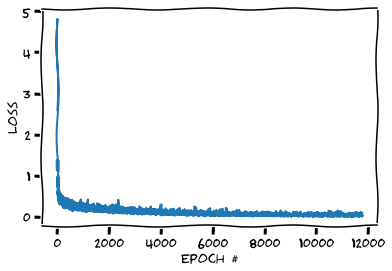

In [20]:
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

### 保存模型 

In [21]:
torch.save(cnn.state_dict(), "fm-cnn3.pth")
# 加载用这个
#cnn.load_state_dict(torch.load("fm-cnn3.pth"))

## 进一步优化

In [22]:
%%time
#修改学习率和批次
cnn.train()
LEARNING_RATE=LEARNING_RATE / 10
TOTAL_EPOCHS=20
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
losses = [];
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        #损失函数直接放到CPU中，因为还有其他的计算
        loss = criterion(outputs, labels).cpu()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))
            

Epoch : 1/20, Iter : 100/234,  Loss: 0.0156
Epoch : 1/20, Iter : 200/234,  Loss: 0.0022
Epoch : 2/20, Iter : 100/234,  Loss: 0.0063
Epoch : 2/20, Iter : 200/234,  Loss: 0.0033
Epoch : 3/20, Iter : 100/234,  Loss: 0.0013
Epoch : 3/20, Iter : 200/234,  Loss: 0.0018
Epoch : 4/20, Iter : 100/234,  Loss: 0.0007
Epoch : 4/20, Iter : 200/234,  Loss: 0.0010
Epoch : 5/20, Iter : 100/234,  Loss: 0.0042
Epoch : 5/20, Iter : 200/234,  Loss: 0.0006
Epoch : 6/20, Iter : 100/234,  Loss: 0.0020
Epoch : 6/20, Iter : 200/234,  Loss: 0.0007
Epoch : 7/20, Iter : 100/234,  Loss: 0.0010
Epoch : 7/20, Iter : 200/234,  Loss: 0.0010
Epoch : 8/20, Iter : 100/234,  Loss: 0.0002
Epoch : 8/20, Iter : 200/234,  Loss: 0.0025
Epoch : 9/20, Iter : 100/234,  Loss: 0.0008
Epoch : 9/20, Iter : 200/234,  Loss: 0.0003
Epoch : 10/20, Iter : 100/234,  Loss: 0.0006
Epoch : 10/20, Iter : 200/234,  Loss: 0.0003
Epoch : 11/20, Iter : 100/234,  Loss: 0.0004
Epoch : 11/20, Iter : 200/234,  Loss: 0.0004
Epoch : 12/20, Iter : 100/23

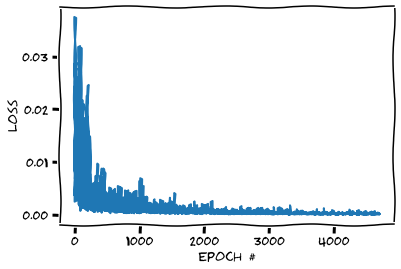

In [23]:
## 可视化一下损失
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

## 再次进行评估

In [24]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('准确率: %.4f %%' % (100 * correct / total))

准确率: 92.0700 %


In [25]:
%%time
#修改学习率和批次
cnn.train()
LEARNING_RATE=LEARNING_RATE / 10
TOTAL_EPOCHS=10
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
losses = [];
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        #损失函数直接放到CPU中，因为还有其他的计算
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))
            

Epoch : 1/10, Iter : 100/234,  Loss: 0.0003
Epoch : 1/10, Iter : 200/234,  Loss: 0.0001
Epoch : 2/10, Iter : 100/234,  Loss: 0.0009
Epoch : 2/10, Iter : 200/234,  Loss: 0.0002
Epoch : 3/10, Iter : 100/234,  Loss: 0.0005
Epoch : 3/10, Iter : 200/234,  Loss: 0.0001
Epoch : 4/10, Iter : 100/234,  Loss: 0.0001
Epoch : 4/10, Iter : 200/234,  Loss: 0.0001
Epoch : 5/10, Iter : 100/234,  Loss: 0.0002
Epoch : 5/10, Iter : 200/234,  Loss: 0.0003
Epoch : 6/10, Iter : 100/234,  Loss: 0.0008
Epoch : 6/10, Iter : 200/234,  Loss: 0.0003
Epoch : 7/10, Iter : 100/234,  Loss: 0.0001
Epoch : 7/10, Iter : 200/234,  Loss: 0.0000
Epoch : 8/10, Iter : 100/234,  Loss: 0.0001
Epoch : 8/10, Iter : 200/234,  Loss: 0.0001
Epoch : 9/10, Iter : 100/234,  Loss: 0.0001
Epoch : 9/10, Iter : 200/234,  Loss: 0.0001
Epoch : 10/10, Iter : 100/234,  Loss: 0.0001
Epoch : 10/10, Iter : 200/234,  Loss: 0.0001
CPU times: user 2min 33s, sys: 8.71 s, total: 2min 41s
Wall time: 2min 20s


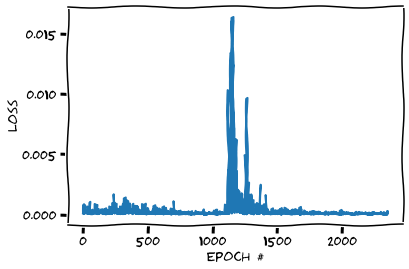

In [26]:
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

In [27]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('准确率: %.4f %%' % (100 * correct / total))

准确率: 92.1500 %


损失小了，但是准确率没有提高，这就说明已经接近模型的瓶颈了，如果再要进行优化，就需要修改模型了。另外还有一个判断模型是否到瓶颈的标准，就是看损失函数，最后一次的训练的损失函数明显的没有下降的趋势，只是在震荡，这说明已经没有什么优化的空间了。

通过简单的操作，我们也能够看到`Adam优化器`的暴力性，我们只要简单的修改学习率就能够达到优化的效果，Adam优化器的使用一般情况下是首先使用0.1进行预热，然后再用0.01进行大批次的训练，最后使用0.001这个学习率进行收尾，再小的学习率一般情况就不需要了。

## 总结
最后我们再总结一下几个超参数:

`BATCH_SIZE`: 批次数量，定义每次训练时多少数据作为一批，这个批次需要在dataloader初始化时进行设置，并且需要这对模型和显存进行配置，如果出现OOM有线减小，一般设为2的倍数

`DEVICE`：进行计算的设备，主要是CPU还是GPU

`LEARNING_RATE`：学习率，反向传播时使用

`TOTAL_EPOCHS`：训练的批次，一般情况下会根据损失和准确率等阈值

其实优化器和损失函数也算超参数，这里就不说了